In [10]:
import torch
import matplotlib.pyplot as plt
from helpers.plot import compare_audios
from helpers.audio_utils import trim_audio
from helpers.path_utils import get_base_dir
from helpers.find_trigger import FindTrigger

AUDIO_NAME = "001-2024-09-09-1746.wav"

mobile_dir = get_base_dir().joinpath("data", "mobile", "last-trigger", AUDIO_NAME)
stethos_dir = get_base_dir().joinpath("data", "stethos", "last-trigger", AUDIO_NAME)

ft = FindTrigger()

mobile, stethos, sample_rate = ft.load_recordings(str(mobile_dir), str(stethos_dir))
mobile.shape, stethos.shape, sample_rate

(torch.Size([1, 489600]), torch.Size([1, 480000]), 4000)

In [11]:
START_AT = None
END_AT = 11

mobile_snippet = trim_audio(mobile, sample_rate, START_AT, END_AT)
stethos_snippet = trim_audio(stethos, sample_rate, START_AT, END_AT)

mobile.shape, mobile_snippet.shape

(torch.Size([1, 489600]), torch.Size([1, 44000]))

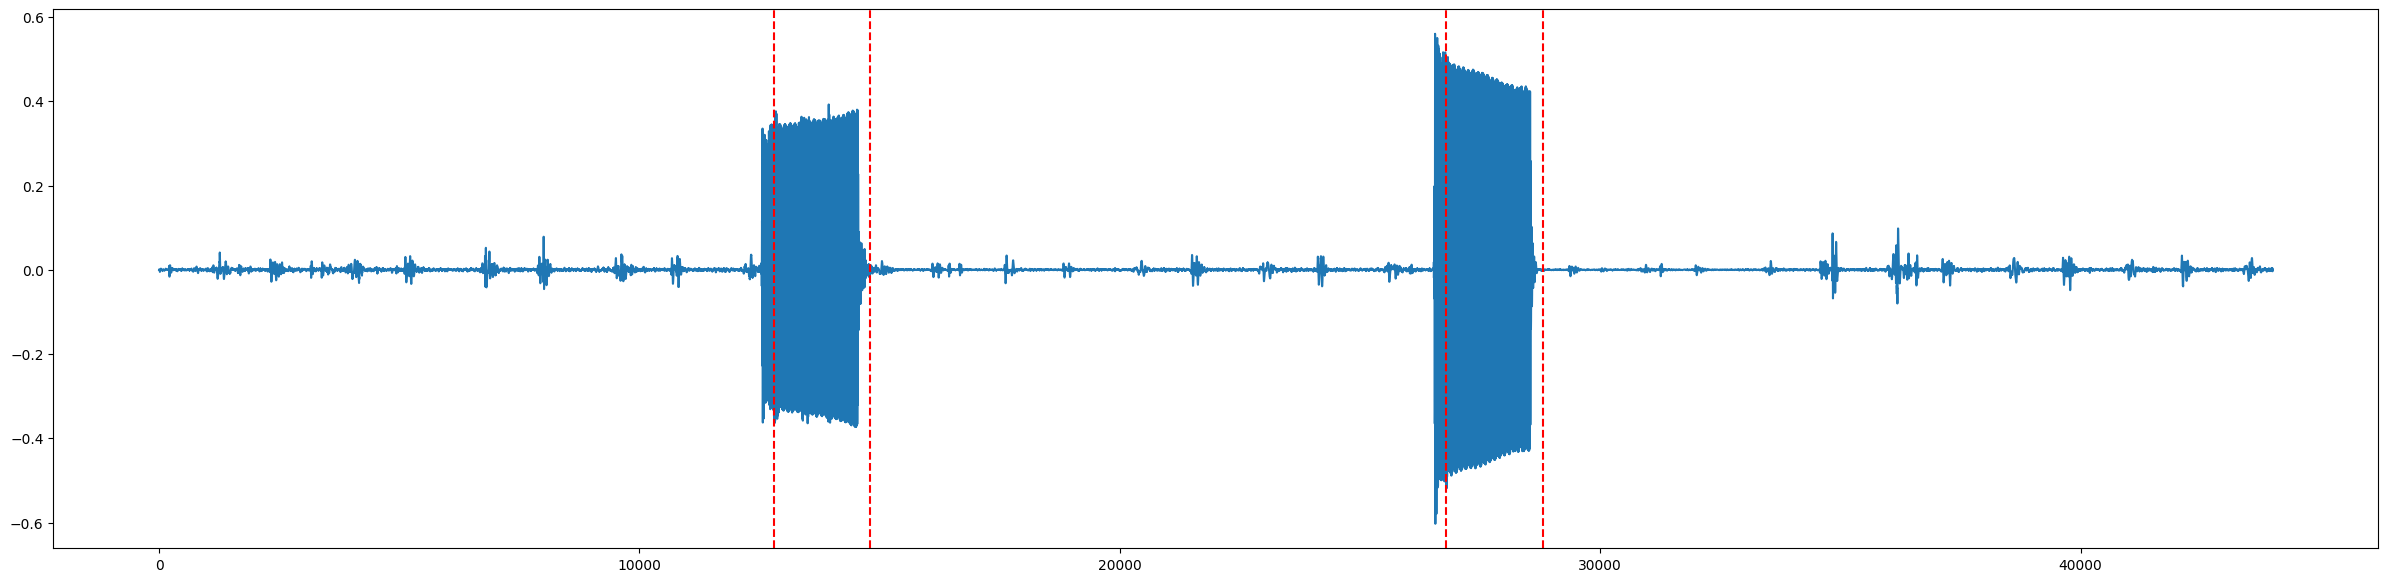

In [12]:
SYNTHETIC_FREQ = 360
DOWNSAMPLE_FACTOR = 400
SIGMA_SMOOTH = 1
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

mobile_triggers = ft.find_trigger_peaks(
    audio=mobile_snippet,
    sample_rate=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
)

plt.figure(figsize=(30, 7))
plt.plot(mobile_snippet.squeeze())

for peak in mobile_triggers:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

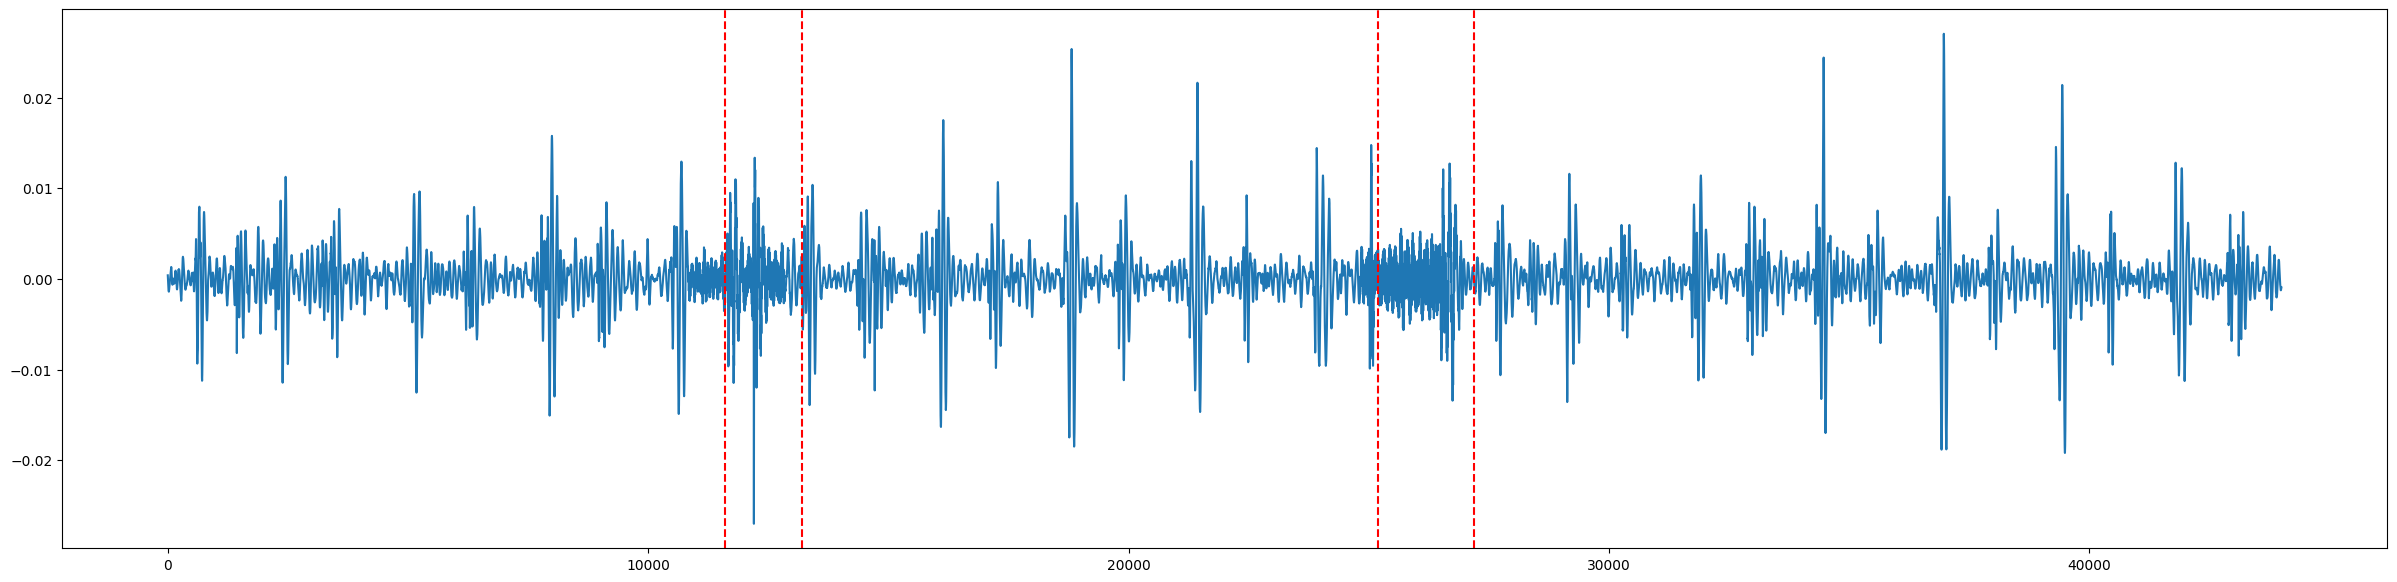

In [13]:
stethos_triggers = ft.find_trigger_peaks(
    audio=stethos_snippet,
    sample_rate=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
)

plt.figure(figsize=(30, 7))
plt.plot(stethos_snippet.squeeze())

for peak in stethos_triggers:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

In [14]:
SNIPPET_SECS = 11

mobile_match, stethos_match = ft.match_last_trigger(
    mobile_audio=mobile,
    stethos_audio=stethos,
    sample_rate=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    snippet_secs=SNIPPET_SECS,
)

torch.Size([1, 452800]) torch.Size([1, 44000])


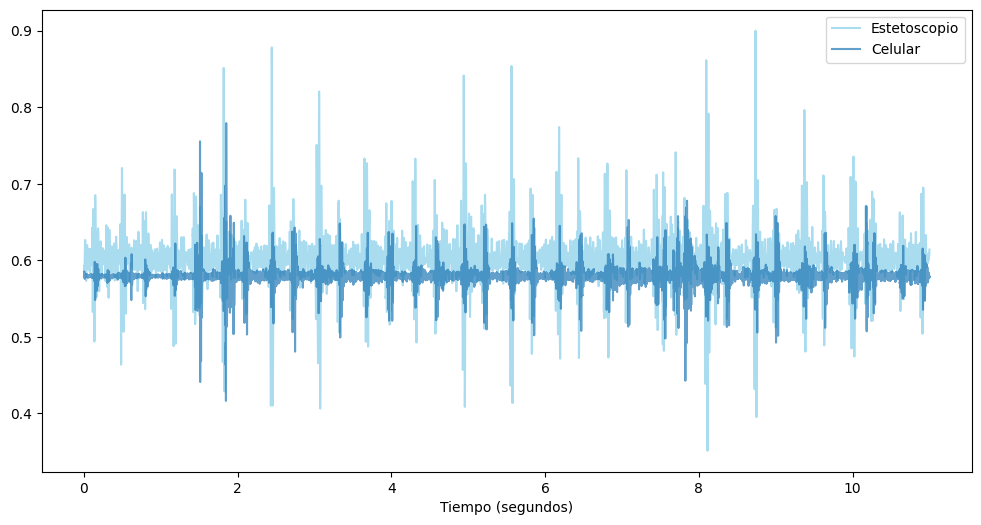

In [15]:
mobile_match_snippet = trim_audio(mobile_match, sample_rate, START_AT, END_AT)
stethos_match_snippet = trim_audio(stethos_match, sample_rate, START_AT, END_AT)

print(mobile_match.shape, mobile_match_snippet.shape)

compare_audios(
    mobile_match_snippet.squeeze(),
    stethos_match_snippet.squeeze(),
    sample_rate,
    offset=0,
)

In [16]:
CHUNK_SECS = 2

mobile_chunks = ft.make_heartbeats_chunks(
    audio=mobile_match, sample_rate=sample_rate, chunk_secs=CHUNK_SECS
)

stethos_chunks = ft.make_heartbeats_chunks(
    audio=stethos_match, sample_rate=sample_rate, chunk_secs=CHUNK_SECS
)

mobile_match.shape, mobile_chunks.shape, stethos_match.shape, stethos_chunks.shape

(torch.Size([1, 452800]),
 torch.Size([57, 1, 8000]),
 torch.Size([1, 452800]),
 torch.Size([57, 1, 8000]))

In [17]:
OUTPUT_DIR = get_base_dir().joinpath("data", "model", "train")

ft.save_match(mobile_chunks, stethos_chunks, sample_rate, OUTPUT_DIR, AUDIO_NAME)

File 'C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\coratech\data\model\train\001-2024-09-09-1746.pt' was saved succesfully!


In [18]:
mobile_final, stethos_final, sample_rate = torch.load(
    OUTPUT_DIR.joinpath(AUDIO_NAME.replace(".wav", ".pt"))
)

mobile_final.shape, stethos_final.shape, sample_rate

(torch.Size([57, 1, 8000]), torch.Size([57, 1, 8000]), 4000)